# Chatbot Intention Classification

## Libraries

In [44]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from collections import Counter
import os


import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, 
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

## Dataset Loading

In [45]:
def load_massive_jsonl(file_path):
    """MASSIVE veri setini yükler"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                item = json.loads(line)
                data.append({
                    'utterance': item['utt'],
                    'intent': item['intent'],
                    'partition': item['partition']
                })
    return pd.DataFrame(data)

FILE_PATH = 'data/tr-TR.jsonl'  # veya '../data/tr-TR.jsonl'

df = load_massive_jsonl(FILE_PATH)

print(f"Veri yüklendi: {len(df)} örnek")
print(f"Intent sınıfı: {df['intent'].nunique()}")
print(f"\nPartition dağılımı:")
print(df['partition'].value_counts())
print(f"\nİlk 5 örnek:")
print(df[['utterance', 'intent']].head())

Veri yüklendi: 16521 örnek
Intent sınıfı: 60

Partition dağılımı:
partition
train    11514
test      2974
dev       2033
Name: count, dtype: int64

İlk 5 örnek:
                              utterance             intent
0     bu hafta beni sabah beşte uyandır          alarm_set
1  beni cuma günü sabah dokuzda uyandır          alarm_set
2          iki saat sonrasına alarm kur          alarm_set
3                                sessiz  audio_volume_mute
4                        olly sessiz ol  audio_volume_mute


## Preprocess

Ön işleme tamamlandı
Toplam 60 intent sınıfı


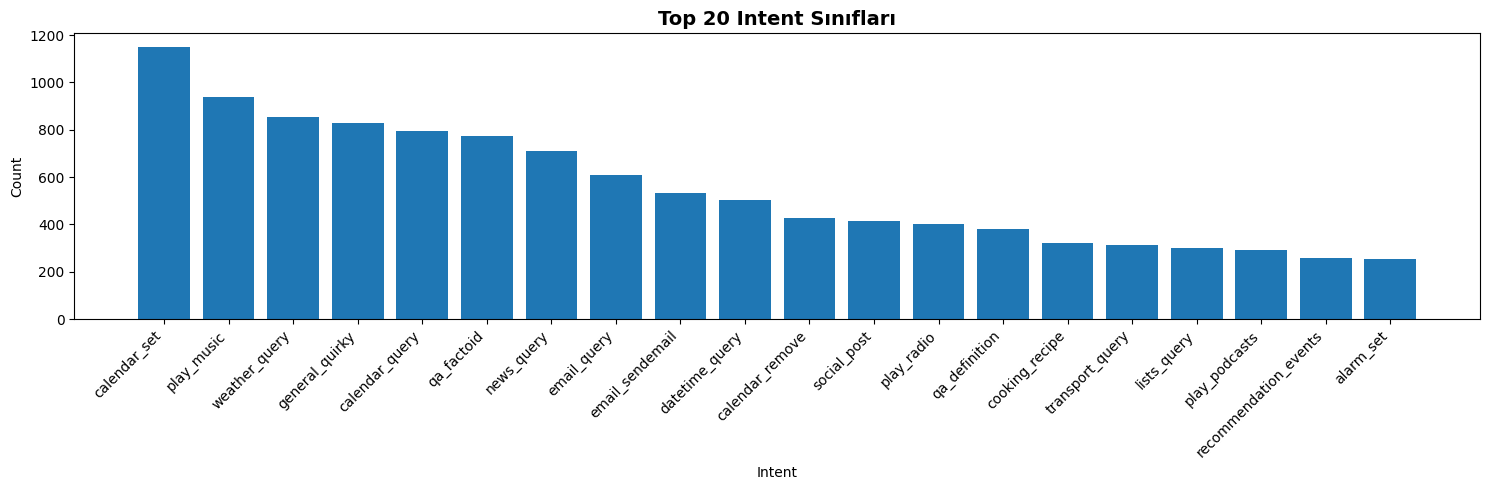

In [46]:
def preprocess_text(text):
    """Türkçe metin temizleme"""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['utterance_clean'] = df['utterance'].apply(preprocess_text)

# Intent encoding
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

print(f"Ön işleme tamamlandı")
print(f"Toplam {len(label_encoder.classes_)} intent sınıfı")

# Intent dağılımını görselleştir
plt.figure(figsize=(15, 5))
top_intents = df['intent'].value_counts().head(20)
plt.bar(range(len(top_intents)), top_intents.values)
plt.xticks(range(len(top_intents)), top_intents.index, rotation=45, ha='right')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.title('Top 20 Intent Sınıfları', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

## Tokenization

Tokenizasyon tamamlandı
Vocabulary size: 12317
X shape: (16521, 25), y shape: (16521,)


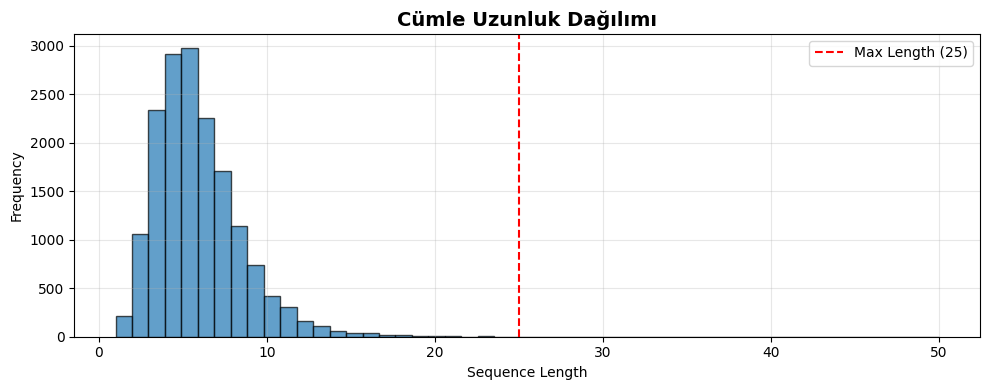

Ortalama uzunluk: 5.51
Max uzunluk: 50


In [47]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 25

# Keras Tokenizer - optimize edilmiş
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',
    char_level=False
)

tokenizer.fit_on_texts(df['utterance_clean'])
sequences = tokenizer.texts_to_sequences(df['utterance_clean'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y = df['intent_encoded'].values

print(f"Tokenizasyon tamamlandı")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Sequence uzunluk dağılımı
seq_lengths = [len(s) for s in sequences]
plt.figure(figsize=(10, 4))
plt.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', linestyle='--', 
            label=f'Max Length ({MAX_SEQUENCE_LENGTH})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Cümle Uzunluk Dağılımı', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Ortalama uzunluk: {np.mean(seq_lengths):.2f}")
print(f"Max uzunluk: {max(seq_lengths)}")

## Train-Test-Validation Split

In [48]:
train_mask = df['partition'] == 'train'
test_mask = df['partition'] == 'test'
dev_mask = df['partition'] == 'dev'

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

if dev_mask.sum() > 0:
    X_val = X[dev_mask]
    y_val = y[dev_mask]
    print("Dev partition kullanıldı")
else:
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
    )
    print("Train'den validation ayrıldı")

NUM_CLASSES = len(label_encoder.classes_)

print(f"\n{'='*50}")
print("VERİ SETİ DAĞILIMI")
print(f"{'='*50}")
print(f"Train:      {len(X_train):>6} örnekler ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val):>6} örnekler ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:       {len(X_test):>6} örnekler ({len(X_test)/len(X)*100:.1f}%)")
print(f"{'='*50}")
print(f"Toplam:     {len(X):>6} örnekler")
print(f"Sınıf sayısı: {NUM_CLASSES}")
print(f"{'='*50}")

Dev partition kullanıldı

VERİ SETİ DAĞILIMI
Train:       11514 örnekler (69.7%)
Validation:   2033 örnekler (12.3%)
Test:         2974 örnekler (18.0%)
Toplam:      16521 örnekler
Sınıf sayısı: 60


## Model Structure

In [36]:
def create_optimized_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    Optimize edilmiş 1D-CNN model
    - BatchNormalization eklendi
    - Daha derin mimari
    - Dropout optimize edildi
    """
    model = Sequential([
        # Embedding Layer
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            embeddings_initializer='glorot_uniform',
            name='embedding'
        ),
        
        # First Conv1D Block
        Conv1D(128, 3, activation='relu', padding='same', name='conv1d_1'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Conv1D Block
        Conv1D(128, 3, activation='relu', padding='same', name='conv1d_2'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Global Max Pooling
        GlobalMaxPooling1D(name='global_max_pooling'),
        
        # Dense Layers
        Dense(256, activation='relu', name='dense_1'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', name='dense_2'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output Layer
        Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Model oluştur
EMBEDDING_DIM = 128 

print("\n" + "="*60)
print("MODEL MİMARİSİ")
print("="*60)

model = create_optimized_model(
    vocab_size=MAX_VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=NUM_CLASSES
)

model.summary()

print(f"\nModel oluşturuldu")
print(f"Toplam parametre: {model.count_params():,}")
print(f"Eğitilebilir parametre: {sum([np.prod(w.shape) for w in model.trainable_weights]):,}")



MODEL MİMARİSİ
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 128)           49280     
                                                                 
 batch_normalization_8 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 25, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           49280     
                                                                 
 batch_normalization_9 (Bat  (None, 25, 128)           512       
 chNormalization)                     

## Compile

In [37]:
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model derlendi")
print(f"Optimizer: Adam (lr={initial_learning_rate})")
print(f"Loss: Sparse Categorical Crossentropy")

Model derlendi
Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy


## Callbacks

In [38]:
os.makedirs('models', exist_ok=True)

callbacks = [
    # Early Stopping
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning Rate Reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    
    # Model Checkpoint
    ModelCheckpoint(
        'models/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks tanımlandı:")
print("  - EarlyStopping (patience=5)")
print("  - ReduceLROnPlateau (patience=3)")
print("  - ModelCheckpoint")

Callbacks tanımlandı:
  - EarlyStopping (patience=5)
  - ReduceLROnPlateau (patience=3)
  - ModelCheckpoint


## Model Training

In [39]:
print("MODEL EĞİTİMİ BAŞLIYOR")
print("="*60)

BATCH_SIZE = 32
EPOCHS = 20

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("EĞİTİM TAMAMLANDI!")

MODEL EĞİTİMİ BAŞLIYOR
Epoch 1/20
358/360 [============================>.] - ETA: 0s - loss: 3.4925 - accuracy: 0.2048
Epoch 1: val_accuracy improved from -inf to 0.05165, saving model to models\best_model.keras
360/360 [==============================] - 10s 22ms/step - loss: 3.4881 - accuracy: 0.2054 - val_loss: 5.0919 - val_accuracy: 0.0516 - lr: 0.0010
Epoch 2/20
358/360 [============================>.] - ETA: 0s - loss: 1.8449 - accuracy: 0.5229
Epoch 2: val_accuracy improved from 0.05165 to 0.57993, saving model to models\best_model.keras
360/360 [==============================] - 7s 19ms/step - loss: 1.8430 - accuracy: 0.5232 - val_loss: 1.7265 - val_accuracy: 0.5799 - lr: 0.0010
Epoch 3/20
359/360 [============================>.] - ETA: 0s - loss: 1.0882 - accuracy: 0.7086
Epoch 3: val_accuracy improved from 0.57993 to 0.74816, saving model to models\best_model.keras
360/360 [==============================] - 7s 20ms/step - loss: 1.0884 - accuracy: 0.7086 - val_loss: 1.0198 - va

## Accuracy Loss Plots

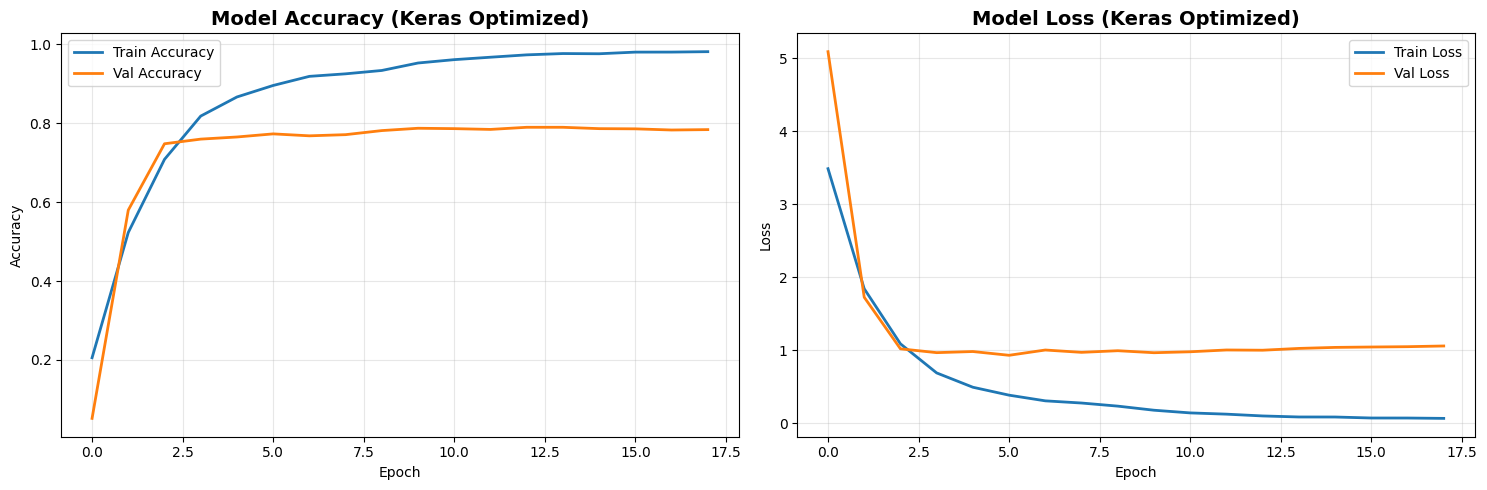


EĞİTİM SONUÇLARI
En iyi epoch: 13
En iyi val accuracy: 0.7900 (79.00%)
Final train accuracy: 0.9818


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy (Keras Optimized)', fontsize=14, weight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss (Keras Optimized)', fontsize=14, weight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# En iyi sonuçları göster
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
print(f"\n{'='*60}")
print("EĞİTİM SONUÇLARI")
print(f"{'='*60}")
print(f"En iyi epoch: {best_epoch + 1}")
print(f"En iyi val accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"{'='*60}")



## Metric Evaluation

In [41]:
print("\n" + "="*60)
print("TEST SETİ DEĞERLENDİRMESİ")
print("="*60)

# Test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Predictions
print("Tahminler yapılıyor...")
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Genel metrikler 
print("\n" + "="*60)
print("GENEL METRİKLER (Tüm Test Seti)")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_classes, average='weighted', zero_division=0
)

print(f"Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)

# Classification Report - Top 20 sınıf için
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Top 20 Sınıf)")
print("="*60)

# Test setinde en sık görülen 20 sınıf
test_intent_counts = pd.Series(y_test).value_counts().head(20)
top_classes = test_intent_counts.index.tolist()

mask = np.isin(y_test, top_classes) & np.isin(y_pred_classes, top_classes)
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_classes[mask]

print(f"Top 20 sınıf için: {mask.sum()} / {len(y_test)} örnek kullanılıyor")

if len(y_test_filtered) > 0:
    # Sadece bu örneklerde görünen sınıflar
    unique_labels = sorted(set(y_test_filtered) | set(y_pred_filtered))
    
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    
    y_test_remapped = np.array([label_mapping[label] for label in y_test_filtered])
    y_pred_remapped = np.array([label_mapping[label] for label in y_pred_filtered])
    
    # Target names
    target_names = [label_encoder.classes_[label] for label in unique_labels]
    
    print(classification_report(
        y_test_remapped,
        y_pred_remapped,
        target_names=target_names,
        digits=4,
        zero_division=0
    ))
else:
    print("Top 20 sınıf için yeterli örnek bulunamadı")

# Sınıf başına accuracy (Top 15)
print("\n" + "="*60)
print("SINIF BAŞINA PERFORMANS (Top 15)")
print("="*60)

class_accuracies = []
for intent_idx in test_intent_counts.head(15).index:
    mask = y_test == intent_idx
    if mask.sum() > 0:
        class_acc = (y_pred_classes[mask] == y_test[mask]).mean()
        intent_name = label_encoder.classes_[intent_idx]
        class_accuracies.append({
            'intent': intent_name,
            'accuracy': class_acc,
            'count': mask.sum()
        })

if class_accuracies:
    class_acc_df = pd.DataFrame(class_accuracies)
    class_acc_df = class_acc_df.sort_values('accuracy', ascending=False)
    
    for idx, row in class_acc_df.iterrows():
        print(f"{row['intent']:<35} Acc: {row['accuracy']:.4f} ({int(row['count'])} örnekler)")
else:
    print("Sınıf bilgisi hesaplanamadı")

print("="*60)

# Confusion matrix bilgisi için en çok karıştırılan sınıflar
print("\n" + "="*60)
print("EN ÇOK KARIŞTIRILAN SINIFLAR (Top 10 Hata)")
print("="*60)

# Yanlış tahminler
wrong_mask = y_test != y_pred_classes
wrong_pairs = list(zip(y_test[wrong_mask], y_pred_classes[wrong_mask]))

if wrong_pairs:
    from collections import Counter
    most_common_errors = Counter(wrong_pairs).most_common(10)
    
    for (true_label, pred_label), count in most_common_errors:
        true_intent = label_encoder.classes_[true_label]
        pred_intent = label_encoder.classes_[pred_label]
        print(f"{true_intent:<25} → {pred_intent:<25} ({count} kez)")
else:
    print("Hiç yanlış tahmin yok! (Mükemmel model)")

print("="*60)


TEST SETİ DEĞERLENDİRMESİ

Test Loss: 1.0386
Test Accuracy: 0.7845 (78.45%)
Tahminler yapılıyor...

GENEL METRİKLER (Tüm Test Seti)
Accuracy:  0.7845 (78.45%)
Precision: 0.8040
Recall:    0.7845
F1-Score:  0.7910

CLASSIFICATION REPORT (Top 20 Sınıf)
Top 20 sınıf için: 1911 / 2974 örnek kullanılıyor
                  precision    recall  f1-score   support

  calendar_query     0.6443    0.8067    0.7164       119
 calendar_remove     0.8767    0.9697    0.9209        66
    calendar_set     0.9153    0.8398    0.8759       206
  cooking_recipe     0.9286    0.7879    0.8525        66
  datetime_query     0.8571    0.9070    0.8814        86
     email_query     0.9182    0.8860    0.9018       114
 email_sendemail     0.9612    0.9000    0.9296       110
  general_quirky     0.5683    0.5603    0.5643       141
iot_hue_lightoff     1.0000    0.9762    0.9880        42
     lists_query     0.8750    0.8750    0.8750        48
    lists_remove     1.0000    0.9000    0.9474        50
 


Confusion Matrix için 10 sınıf seçildi


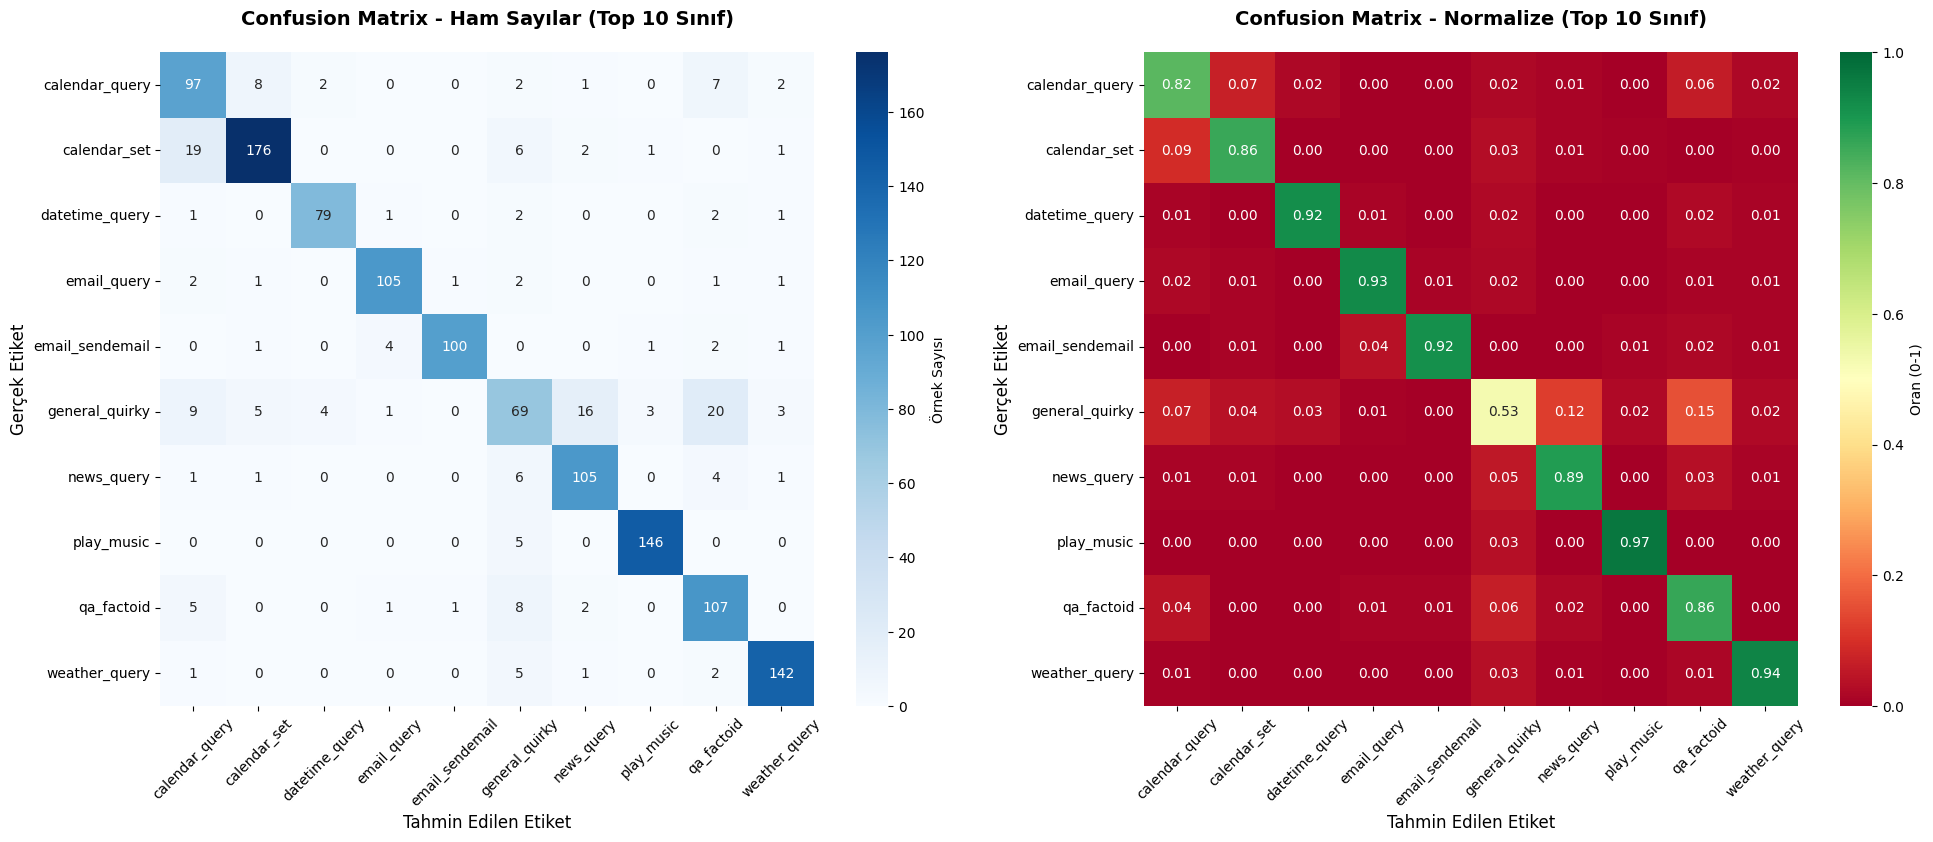


SINIF BAŞINA DOĞRULUK (Confusion Matrix'ten)
calendar_query                       97/119 = 0.815
calendar_set                        176/205 = 0.859
datetime_query                       79/86  = 0.919
email_query                         105/113 = 0.929
email_sendemail                     100/109 = 0.917
general_quirky                       69/130 = 0.531
news_query                          105/118 = 0.890
play_music                          146/151 = 0.967
qa_factoid                          107/124 = 0.863
weather_query                       142/151 = 0.940

EN ÇOK KARIŞTIRILAN ÇIFTLER (Top 10)
general_quirky                 → qa_factoid                     (20 kez)
calendar_set                   → calendar_query                 (19 kez)
general_quirky                 → news_query                     (16 kez)
general_quirky                 → calendar_query                 (9 kez)
calendar_query                 → calendar_set                   (8 kez)
qa_factoid                     → 

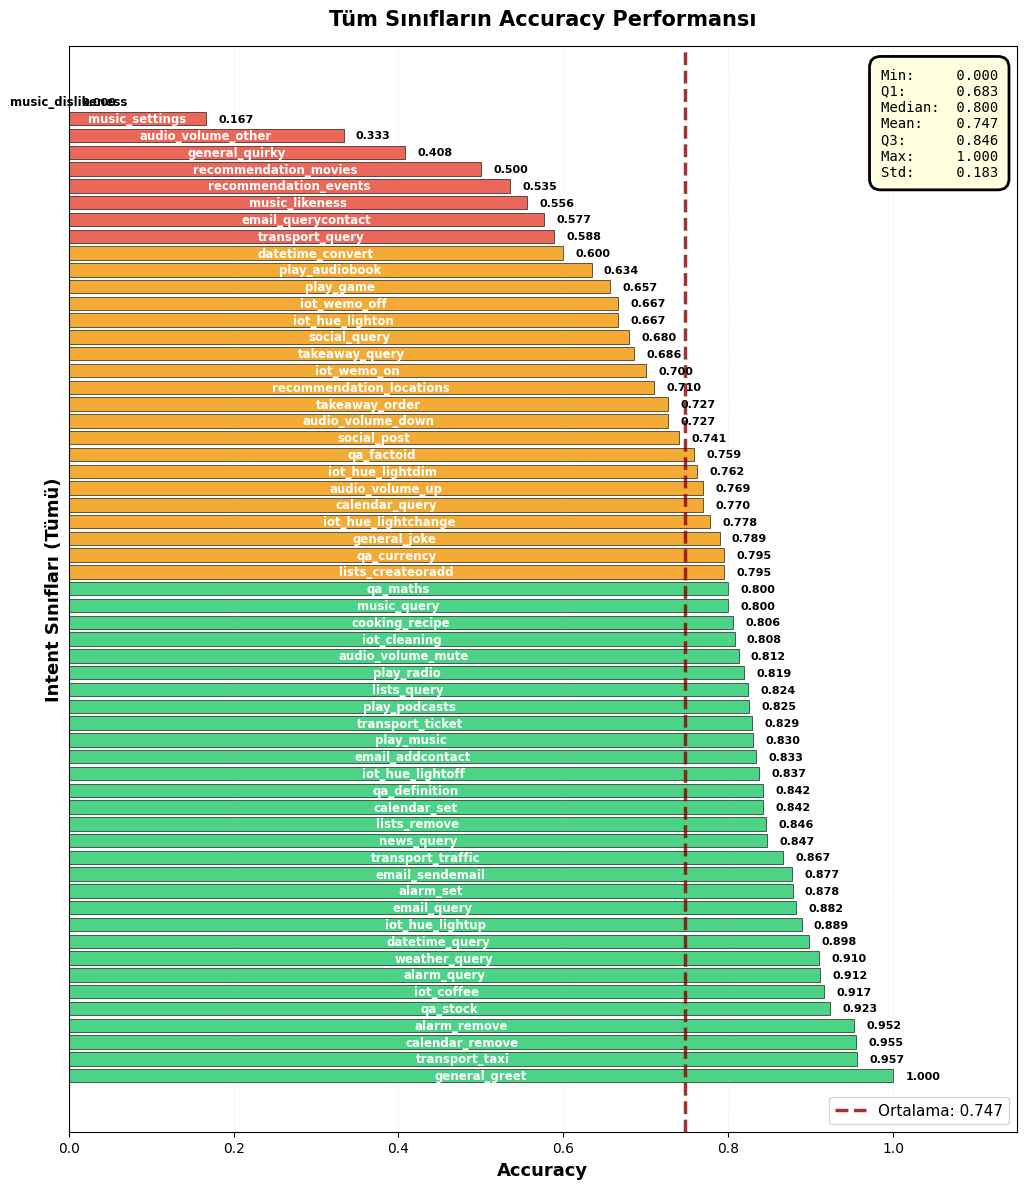

In [56]:
top_n = 10 

# Test setinde en sık görülen sınıflar
test_counts = pd.Series(y_test).value_counts()
top_true_classes = test_counts.head(top_n).index.tolist()

# Tahminlerde en sık görülen sınıflar
pred_counts = pd.Series(y_pred_classes).value_counts()
top_pred_classes = pred_counts.head(top_n).index.tolist()

# Her iki listede de olan sınıflar (kesişim)
common_classes = sorted(set(top_true_classes) & set(top_pred_classes))

# Eğer çok az kesişim varsa, union
if len(common_classes) < 8:
    common_classes = sorted(set(top_true_classes) | set(top_pred_classes))
    common_classes = common_classes[:top_n]  # İlk 10'u al

print(f"\nConfusion Matrix için {len(common_classes)} sınıf seçildi")

# Filtreleme: Sadece seçili sınıflardaki örnekler
mask = np.isin(y_test, common_classes) & np.isin(y_pred_classes, common_classes)
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_classes[mask]

if len(y_test_filtered) > 50: 
    # Confusion matrix 
    cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=common_classes)
    
    # Intent isimleri
    class_names = [label_encoder.classes_[i] for i in common_classes]
    
    # Kısaltılmış isimler
    class_names_short = []
    for name in class_names:
        if len(name) > 15:
            class_names_short.append(name[:12] + '...')
        else:
            class_names_short.append(name)
    
    # Normalize edilmiş confusion matrix (yüzde olarak)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # NaN'ları 0 yap
    
    # Görselleştirme - 2 ayrı grafik
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. HAM SAYILAR
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names_short,
        yticklabels=class_names_short,
        cbar_kws={'label': 'Örnek Sayısı'},
        ax=axes[0],
        square=True
    )
    axes[0].set_title(f'Confusion Matrix - Ham Sayılar (Top {len(common_classes)} Sınıf)', 
                      fontsize=14, weight='bold', pad=20)
    axes[0].set_ylabel('Gerçek Etiket', fontsize=12)
    axes[0].set_xlabel('Tahmin Edilen Etiket', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # 2. NORMALIZE (Yüzde)
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        xticklabels=class_names_short,
        yticklabels=class_names_short,
        cbar_kws={'label': 'Oran (0-1)'},
        ax=axes[1],
        square=True,
        vmin=0,
        vmax=1
    )
    axes[1].set_title(f'Confusion Matrix - Normalize (Top {len(common_classes)} Sınıf)', 
                      fontsize=14, weight='bold', pad=20)
    axes[1].set_ylabel('Gerçek Etiket', fontsize=12)
    axes[1].set_xlabel('Tahmin Edilen Etiket', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Diagonal (doğru tahminler) analizi
    print("\n" + "="*60)
    print("SINIF BAŞINA DOĞRULUK (Confusion Matrix'ten)")
    print("="*60)
    
    for i, class_idx in enumerate(common_classes):
        total = cm[i].sum()
        correct = cm[i, i]
        accuracy = correct / total if total > 0 else 0
        intent_name = label_encoder.classes_[class_idx]
        print(f"{intent_name:<35} {correct:>3}/{total:<3} = {accuracy:.3f}")
    
    print("="*60)
    
    # En çok karıştırılan çiftler (diagonal dışı)
    print("\n" + "="*60)
    print("EN ÇOK KARIŞTIRILAN ÇIFTLER (Top 10)")
    print("="*60)
    
    confusion_pairs = []
    for i in range(len(common_classes)):
        for j in range(len(common_classes)):
            if i != j and cm[i, j] > 0:  # Diagonal dışı
                confusion_pairs.append({
                    'true': label_encoder.classes_[common_classes[i]],
                    'pred': label_encoder.classes_[common_classes[j]],
                    'count': cm[i, j]
                })
    
    confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)
    
    for pair in confusion_pairs[:10]:
        print(f"{pair['true']:<30} → {pair['pred']:<30} ({pair['count']} kez)")
    
    print("="*60)

else:
    print("Yeterli örnek bulunamadı, confusion matrix çizilemiyor")
    print(f" Filtrelenen örnek sayısı: {len(y_test_filtered)}")

#Genel accuracy dağılımı (histogram)
print("\n" + "="*60)
print("SINIF ACCURACY DAĞILIMI")
print("="*60)

# Tüm sınıflar için accuracy
all_class_accuracies = []
for intent_idx in range(NUM_CLASSES):
    mask = y_test == intent_idx
    if mask.sum() > 0:
        class_acc = (y_pred_classes[mask] == y_test[mask]).mean()
        all_class_accuracies.append(class_acc)

if all_class_accuracies:
    plt.figure(figsize=(20, 12))
    plt.subplot(1, 2, 1)
    
    # Her sınıf için accuracy hesapla
    class_acc_data = []
    for intent_idx in range(NUM_CLASSES):
        mask = y_test == intent_idx
        if mask.sum() > 0:
            class_acc = (y_pred_classes[mask] == y_test[mask]).mean()
            intent_name = label_encoder.classes_[intent_idx]
            support = mask.sum()
            class_acc_data.append((intent_name, class_acc, support))
    
    # Accuracy'e göre sırala
    class_acc_data.sort(key=lambda x: x[1], reverse=True)
    
    intent_names = [name for name, _, _ in class_acc_data]
    accuracies = [acc for _, acc, _ in class_acc_data]
    supports = [sup for _, _, sup in class_acc_data]
    
    y_pos = np.arange(len(intent_names))
    colors = ['#2ecc71' if v >= 0.8 else '#f39c12' if v >= 0.6 else '#e74c3c' for v in accuracies]
    
    # Horizontal bar chart - daha kalın çubuklar
    bars = plt.barh(y_pos, accuracies, height=0.8, color=colors, alpha=0.85, 
                    edgecolor='black', linewidth=0.5)
    
    # Ortalama çizgisi
    plt.axvline(np.mean(accuracies), color='darkred', linestyle='--', 
                linewidth=2.5, label=f'Ortalama: {np.mean(accuracies):.3f}', alpha=0.8)
    
    # Y eksenini gizle
    plt.yticks([])
    
    # Sınıf isimlerini çubukların içine yerleştir
    for i, (name, acc, sup) in enumerate(zip(intent_names, accuracies, supports)):
        text_color = 'white' if acc > 0.15 else 'black'
        
        # İsim çubuğun tam ortasına
        # Çok uzun isimleri kısalt
        display_name = name if len(name) <= 25 else name[:22] + '...'
        
        plt.text(acc / 2, i, display_name, 
                ha='center', va='center', fontsize=8.5, 
                color=text_color, weight='bold')
        
        # Accuracy değerini çubuğun sonuna (dışına) yaz
        plt.text(acc + 0.015, i, f'{acc:.3f}', 
                ha='left', va='center', fontsize=8, 
                color='black', weight='bold')
    
    plt.xlabel('Accuracy', fontsize=13, weight='bold')
    plt.ylabel('Intent Sınıfları (Tümü)', fontsize=13, weight='bold')
    plt.title('Tüm Sınıfların Accuracy Performansı', fontsize=15, weight='bold', pad=15)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.2, axis='x', linestyle='--', linewidth=0.5)
    plt.xlim([0, 1.15])  # Sağda accuracy değerleri için yer
    
    
    stats_text = f"""
Min:     {min(accuracies):.3f}
Q1:      {np.percentile(accuracies, 25):.3f}
Median:  {np.median(accuracies):.3f}
Mean:    {np.mean(accuracies):.3f}
Q3:      {np.percentile(accuracies, 75):.3f}
Max:     {max(accuracies):.3f}
Std:     {np.std(accuracies):.3f}
"""

# Grafiğin sağ üst köşesine yerleştir
    plt.text(0.98, 0.98, stats_text.strip(), 
        ha='right', va='top', fontsize=10, family='monospace',
        transform=plt.gca().transAxes,  # Eksen koordinatlarını kullan (0-1 arası)
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                 edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    plt.show()
   

In [43]:
def predict_intent(text, model, tokenizer, label_encoder, max_length=25, top_k=3):
    """
    Verilen Türkçe metin için niyet tahmini
    
    Args:
        text: Türkçe cümle
        top_k: En olası k niyet
    
    Returns:
        List of (intent, confidence) tuples
    """
    # Preprocess
    text_clean = preprocess_text(text)
    
    # Tokenize
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    
    # Predict
    pred = model.predict(padded, verbose=0)[0]
    
    # Top-k sonuçları
    top_indices = np.argsort(pred)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        intent = label_encoder.inverse_transform([idx])[0]
        confidence = pred[idx]
        results.append((intent, confidence))
    
    return results

# Test örnekleri
test_examples = [
    "yarın hava nasıl olacak",
    "saat kaç şu an",
    "bana müzik çal",
    "beni sabah yedide uyandır",
    "bir şaka anlat",
    "bugünkü hava durumu nedir",
    "alarm kur",
    "takvimime randevu ekle",
    "sesli mesaj gönder",
    "radyoyu aç",
    "İstanbul'da hava nasıl",
    "bana bir hatırlatma yap"
]

print("\n" + "="*60)
print("ÖRNEK TAHMİNLER")
print("="*60)

for example in test_examples:
    results = predict_intent(example, model, tokenizer, label_encoder, MAX_SEQUENCE_LENGTH)
    print(f"\n Cümle: '{example}'")
    print(f"   Top 3 Tahmin:")
    for i, (intent, conf) in enumerate(results, 1):
        print(f"   {i}. {intent}: {conf:.2%}")


ÖRNEK TAHMİNLER

 Cümle: 'yarın hava nasıl olacak'
   Top 3 Tahmin:
   1. weather_query: 99.97%
   2. general_quirky: 0.01%
   3. qa_factoid: 0.00%

 Cümle: 'saat kaç şu an'
   Top 3 Tahmin:
   1. datetime_query: 99.98%
   2. calendar_query: 0.01%
   3. music_query: 0.00%

 Cümle: 'bana müzik çal'
   Top 3 Tahmin:
   1. play_music: 99.77%
   2. play_radio: 0.12%
   3. play_audiobook: 0.08%

 Cümle: 'beni sabah yedide uyandır'
   Top 3 Tahmin:
   1. alarm_set: 99.76%
   2. calendar_set: 0.18%
   3. iot_hue_lightup: 0.03%

 Cümle: 'bir şaka anlat'
   Top 3 Tahmin:
   1. general_joke: 97.11%
   2. qa_factoid: 1.00%
   3. qa_definition: 0.84%

 Cümle: 'bugünkü hava durumu nedir'
   Top 3 Tahmin:
   1. weather_query: 99.97%
   2. qa_factoid: 0.01%
   3. general_quirky: 0.00%

 Cümle: 'alarm kur'
   Top 3 Tahmin:
   1. alarm_set: 99.84%
   2. calendar_set: 0.13%
   3. alarm_query: 0.01%

 Cümle: 'takvimime randevu ekle'
   Top 3 Tahmin:
   1. calendar_set: 99.97%
   2. calendar_query: 0.03%

In [60]:
model.save('models/turkish_intent_classifier_keras.keras')

# Tokenizer kaydet
with open('models/tokenizer_keras.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Label encoder kaydet
with open('models/label_encoder_keras.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Config kaydet
config = {
    'max_vocab_size': MAX_VOCAB_SIZE,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'embedding_dim': EMBEDDING_DIM,
    'num_classes': NUM_CLASSES,
    'test_accuracy': float(test_acc),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1': float(f1),
    'intents': label_encoder.classes_.tolist()
}

with open('models/model_config_keras.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print("\n" + "="*60)
print("MODEL VE ARAÇLAR KAYDEDİLDİ")
print("="*60)
print("Kaydedilen dosyalar:")
print("  turkish_intent_classifier_keras.keras")
print("  tokenizer_keras.pkl")
print("  label_encoder_keras.pkl")
print("  model_config_keras.json")
print("  best_model.keras (en iyi checkpoint)")


MODEL VE ARAÇLAR KAYDEDİLDİ
Kaydedilen dosyalar:
  turkish_intent_classifier_keras.keras
  tokenizer_keras.pkl
  label_encoder_keras.pkl
  model_config_keras.json
  best_model.keras (en iyi checkpoint)


In [61]:
def load_saved_model():
    """Kaydedilmiş modeli yükle"""
    model = keras.models.load_model('turkish_intent_classifier_keras.keras')
    
    with open('models/tokenizer_keras.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    
    with open('models/label_encoder_keras.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    with open('models/model_config_keras.json', 'r') as f:
        config = json.load(f)
    
    return model, tokenizer, label_encoder, config

# Kullanım örneği
print("\n" + "="*60)
print("MODEL YÜKLEME ÖRNEĞİ")
print("="*60)
print("""
# Modeli yüklemek için:
loaded_model, loaded_tokenizer, loaded_label_encoder, config = load_saved_model()

# Tahmin yapmak için:
results = predict_intent(
    "alarm kur", 
    loaded_model, 
    loaded_tokenizer, 
    loaded_label_encoder
)

print(f"Tahmin: {results[0][0]} ({results[0][1]:.2%})")
""")


print(f"\nSONUÇLAR:")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"{'='*60}")
print(f"Model Boyutu:   {model.count_params():,} parametre")
print(f"Intent Sınıfı:  {NUM_CLASSES}")
print(f"Train Örnekler: {len(X_train):,}")
print(f"Test Örnekler:  {len(X_test):,}")
print(f"{'='*60}")
print("\n Model başarıyla eğitildi ve kaydedildi!")


MODEL YÜKLEME ÖRNEĞİ

# Modeli yüklemek için:
loaded_model, loaded_tokenizer, loaded_label_encoder, config = load_saved_model()

# Tahmin yapmak için:
results = predict_intent(
    "alarm kur", 
    loaded_model, 
    loaded_tokenizer, 
    loaded_label_encoder
)

print(f"Tahmin: {results[0][0]} ({results[0][1]:.2%})")


SONUÇLAR:
Test Accuracy:  0.7818 (78.18%)
Precision:      0.7944
Recall:         0.7818
F1-Score:       0.7831
Model Boyutu:   1,454,780 parametre
Intent Sınıfı:  60
Train Örnekler: 11,514
Test Örnekler:  2,974

 Model başarıyla eğitildi ve kaydedildi!
